# Hybrid Classical Quantum AutoEncoder for anomaly detection

# Qiskit Implementation
Run this section if you have qiskit-machine-learning installed

## VQC
The VQC implemented is the number 10 of the reference paper, which essentially is a stack Pauli $YX$ rotation gate and a circular series of controlled $CX$, stacked while alternated with an encoding based on the Pauli $X$ rotation

In [ ]:
from qiskit.circuit import QuantumCircuit, Gate, ParameterVector
from qiskit.opflow.expectations import PauliExpectation
from qiskit_machine_learning.connectors import TorchConnector

def get_encoding_block(nqubits: int, features: ParameterVector) -> Gate:
    """ n parameters required """
    assert len(features) == nqubits 
    block = QuantumCircuit(nqubits, name="Encoding Block")
    for i in range(nqubits):
        block.rx(features[i], i)
    return block.to_gate()

def get_ansatz_block(nqubits: int, parameters: ParameterVector) -> Gate:
    """
    need 2n parameters
    """
    assert nqubits * 2 == len(parameters)
    block = QuantumCircuit(nqubits, name="Ansatz Block")
    for i in range(nqubits):
        block.ry(parameters[i], i)
        block.rx(parameters[i + nqubits], i)
    if nqubits > 1:
        block.cx(nqubits - 1, 0)
        for i in range(nqubits - 1):
            block.cx(i, i + 1)
    return block.to_gate()

def get_ansatz(nqubits: int, parameters: ParameterVector, features: ParameterVector, reps: int=3) -> QuantumCircuit:
    assert len(parameters) == reps * 2 * nqubits
    ansatz = QuantumCircuit(nqubits)
    ansatz.compose(get_ansatz_block(nqubits, parameters[:2 * nqubits]), range(nqubits), inplace=True)
    for i in range(1, reps):
        ansatz.barrier()
        ansatz.compose(get_encoding_block(nqubits, features), range(nqubits), inplace=True)
        ansatz.barrier()
        ansatz.compose(get_ansatz_block(nqubits, parameters[2 * nqubits * i :2 * nqubits * (i + 1)]), range(nqubits), inplace=True)
    return ansatz

def get_ansatz_ws(nqubits: int, parameters: ParameterVector, features: ParameterVector, reps: int=3) -> QuantumCircuit:
    assert len(parameters) == 2 * nqubits
    ansatz = QuantumCircuit(nqubits)
    ansatz.compose(get_ansatz_block(nqubits, parameters), range(nqubits), inplace=True)
    for i in range(1, reps):
        ansatz.barrier()
        ansatz.compose(get_encoding_block(nqubits, features), range(nqubits), inplace=True)
        ansatz.barrier()
        ansatz.compose(get_ansatz_block(nqubits, parameters), range(nqubits), inplace=True)
    return ansatz


In [ ]:
from qiskit.utils import algorithm_globals
algorithm_globals.random_seed = 528491

size = (10, 4)
data = algorithm_globals.random.random(size)
nqubits = data.shape[1]
print(data, nqubits)

In [ ]:
input = ParameterVector("x", data.shape[1])
weights = ParameterVector("theta", nqubits * 2)
circuit_ws = get_ansatz_ws(nqubits, weights, input)
circuit_ws.decompose().draw("mpl")


In [ ]:
random_weights_ws = algorithm_globals.random.random(2 * nqubits)
print(random_weights_ws)

In [ ]:
from qiskit_machine_learning.neural_networks import SamplerQNN

sqnn_ws = SamplerQNN(
    circuit=circuit_ws,
    input_params=input,
    weight_params=weights,
    interpret=lambda x: "{:b}".format(x).count('1') % 2 == 0, # parity check
    output_shape=2
)
print(sqnn_ws)

In [ ]:
sampler_qnn_forward = sqnn_ws.forward(data[0], random_weights_ws) # require encoding + ansatz parameters, result is a ndarray
print(f"Forward pass result for SamplerQNN: {sampler_qnn_forward}. \nShape: {sampler_qnn_forward.shape}")


In [ ]:
input1 = ParameterVector("x1", data.shape[1])
weights1 = ParameterVector("theta1", nqubits * 2 * 3)
circuit = get_ansatz(nqubits, weights1, input1)
circuit.draw()


In [ ]:
def parity(x):
    print(x, str(x), "{:b}".format(x), "{:b}".format(x).count('1') % 2)
    return "{:b}".format(x).count('1') % 2

def custom_interpret(x):
    return "{:b}".format(x).count('1') % 4


sqnn = SamplerQNN(
    circuit=circuit,
    input_params=input1,
    weight_params=weights1,
    interpret=lambda x: custom_interpret(x), # parity check
    output_shape=4
)
print(sqnn)

In [ ]:
random_weights = algorithm_globals.random.random(len(weights1))
sampler_qnn_forward = sqnn.forward(data[0], random_weights) # require encoding + ansatz parameters, result is a ndarray
print(f"Forward pass result for SamplerQNN: {sampler_qnn_forward}. \nShape: {sampler_qnn_forward.shape}")

In [ ]:
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit.quantum_info import SparsePauliOp
from qiskit.opflow.expectations import PauliExpectation

def get_Z_expectation_qubitwise(nqubits: int) -> list:
    """
        :nqubits
        the number of qubits to evaluate
        :return
        the qubitwise observables for each Z expectation value, which follows the formula P(1) = (1 - Exp) / 2
    """
    obs = []
    for i in range(nqubits):
        string = "I" * i + "Z" + "I" * (nqubits - (i + 1))
        obs.append(SparsePauliOp.from_list([(string, 1)]))
    return obs

ob = get_Z_expectation_qubitwise(4)
print(ob)

# observable1 = SparsePauliOp.from_list([("Z", 1), ("Z", 1), ("Z", 1), ("I", 1)])
eqnn_ws = EstimatorQNN(
    circuit=circuit_ws,
    input_params=input,
    weight_params=weights,
    observables=ob
)

print(eqnn_ws)
circuit_ws.draw()

In [ ]:
result = eqnn_ws.forward(data[0], random_weights_ws)
print(result)

## Classic AutoEncoder Wrapper

## Using Qiskit & TorchConnector

In [ ]:
import torch.nn as nn
import torch
from sklearn.ensemble import IsolationForest

class HAE(nn.Module):
    """
        general structure is:
        - encoder, FC input_size -> 54 -> 4
        - qnn
        - decoder, FC 4 -> 54 -> input_size
        - tanh activations
    """

    def __init__(self, qnn, input_size: int, nqubits: int = 4) -> None:
        super(HAE, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 54),
            nn.Tanh(),
            nn.Linear(54, nqubits),
            nn.Tanh()
        )
        self.vqc = TorchConnector(qnn)
        self.decoder = nn.Sequential(
            nn.Linear(nqubits, 54),
            nn.Tanh(),
            nn.Linear(54, input_size)
        )

        self.isolation_forest = IsolationForest()

    def forward(self, X):
        X = self.encoder(X)
        X = self.vqc(X)
        X = (torch.ones_like(X) - X) / 2
        X = self.decoder(X)
        return X
    
    def encode(self, X):
        C = self.encoder(X)
        return self.vqc(C)
    
    @torch.no_grad()
    def predict(self, X, fit: bool = False):
        code = self.encode(X).cpu()
        if fit:
            self.isolation_forest.fit(code)
        return self.isolation_forest.predict(code) # return +1 if inlier and -1 otherwise

## Using TorchQuantum

In [1]:
import torch
import torchquantum as tq
import torchquantum.functional as tqf
import torch.nn as nn
from sklearn.ensemble import IsolationForest
from torch.utils.data import DataLoader, Dataset, Subset

from tqdm import tqdm
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

class HAEBottleneck(tq.QuantumModule):
    # initially non parametrized, circuit 10 with 3 reps
    def __init__(self, nqubits: int = 4, n_reps: int = 3):

        def create_blocks(nqubits: int):
            return [(tq.RY(has_params=True, trainable=True), tq.RX(has_params=True, trainable=True)) for _ in range(nqubits)]

        def get_encoder_list(nqubits: int):
            return [{'input_idx': [i], 'func': 'rx', 'wires': [i]} for i in range(nqubits)]

        def get_observables(nqubits: int):
            return [[tq.PauliZ() if j == i else tq.I() for j in range(nqubits)] for i in range(nqubits)]
        
        super(HAEBottleneck, self).__init__()
        
        self.qd = tq.QuantumDevice(n_wires=nqubits) 
        self.n_qubits = nqubits
        self.n_reps = n_reps
        self.encoder = tq.GeneralEncoder(get_encoder_list(nqubits))
        self.measure = tq.MeasureAll(obs=tq.PauliZ)
        # self.observables = get_observables(nqubits)
        self.blocks: list[ # block-wise
            list[ # qubit-wise
            tuple[tq.RY, tq.RX]]] = [create_blocks(nqubits) for _ in range(n_reps)]

    def forward(self, X: torch.Tensor):

        def apply_block(block: list[tuple[tq.RY, tq.RX]]):
            for qubit, gates in enumerate(block):
                (gates[0])(self.qd, wires=qubit) # Y gate
                (gates[1])(self.qd, wires=qubit) # X gate

        def cnot_block():
            if self.n_qubits == 1:
                return
            tqf.cnot(self.qd, wires=[self.n_qubits - 1, 0])
            for i in range(self.n_qubits - 1):
                tqf.cnot(self.qd, wires=[i, i + 1])

        batch_size = X.shape[0]
        # BLOCK 1
        apply_block(self.blocks[0])
        cnot_block()
        # Other BLOCKS
        for rep in range(1, len(self.blocks)):
            self.encoder(self.qd, X)
            apply_block(self.blocks[rep])
            cnot_block()
        """     # A MORE FLEXIBLE MEASURE
        e0 = tq.expval(self.qd, [i for i in range(4)], self.observables[0]) # 1 x B
        e1 = tq.expval(self.qd, [i for i in range(4)], self.observables[1])
        e2 = tq.expval(self.qd, [i for i in range(4)], self.observables[2])
        e3 = tq.expval(self.qd, [i for i in range(4)], self.observables[3])
        E = torch.stack((e0[:, 0], e1[:, 1], e2[:, 2], e3[:, 3]), dim=0).T  # 4 x B
        print((e0[:, 0], e1[:, 1], e2[:, 2], e3[:, 3]))
        """
        Z = self.measure(self.qd)
        return Z


class HAE_TQ(nn.Module):
    """
        general structure is:
        - encoder, FC input_size -> 54 -> 4
        - qnn
        - decoder, FC 4 -> 54 -> input_size
        - tanh activations
    """

    def __init__(self, input_size: int, nqubits: int = 4, n_reps: int = 3) -> None:
        super(HAE_TQ, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_size, 54),
            nn.Tanh(),
            nn.Linear(54, nqubits),
            nn.Tanh()
        )
        self.vqc = HAEBottleneck(nqubits, n_reps)
        self.decoder = nn.Sequential(
            nn.Linear(nqubits, 54),
            nn.Tanh(),
            nn.Linear(54, input_size)
        )

        self.isolation_forest = IsolationForest()

    def forward(self, X):
        X = self.encoder(X)
        X = self.vqc(X)
        # X = (torch.ones_like(X) - X) / 2
        X = self.decoder(X)
        return X

    def encode(self, X):
        C = self.encoder(X)
        return self.vqc(C)

    @torch.no_grad()
    def predict(self, X, fit: bool = False):
        code = self.encode(X).cpu()
        if fit:
            self.isolation_forest.fit(code)
        return self.isolation_forest.predict(code)  # return +1 if inlier and -1 otherwiseimport torch

cuda


In [2]:
import torch.nn as nn
class HAE_C(nn.Module):
    """
        general structure is:
        - encoder, FC input_size -> 54 -> 4
        - qnn
        - decoder, FC 4 -> 54 -> input_size
        - tanh activations
    """

    def __init__(self, input_size: int, nqubits: int = 4) -> None:
        super(HAE_C, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_size, 54),
            nn.Tanh(),
            nn.Linear(54, nqubits),
            nn.Tanh()
        )
        self.bottleneck = nn.Sequential(
            nn.Linear(nqubits, 16),
            nn.Tanh(),
            nn.Linear(16, nqubits)
        )
        self.decoder = nn.Sequential(
            nn.Linear(nqubits, 54),
            nn.Tanh(),
            nn.Linear(54, input_size)
        )

        self.isolation_forest = IsolationForest()

    def forward(self, X):
        X = self.encoder(X)
        X = self.bottleneck(X)
        # X = (torch.ones_like(X) - X) / 2
        X = self.decoder(X)
        return X

    def encode(self, X):
        C = self.encoder(X)
        return self.bottlenack(C)

    @torch.no_grad()
    def predict(self, X, fit: bool = False):
        code = self.encode(X).cpu()
        if fit:
            self.isolation_forest.fit(code)
        return self.isolation_forest.predict(code)  # return +1 if inlier and -1 otherwiseimport torch


In [ ]:
ins = 4
input = torch.rand((100, ins))
print(input)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
test = HAE(eqnn_ws, input_size=279).to(device)

# Some Training & Evaluation functions

In [ ]:
a = torch.Tensor()
print(a)
a = torch.cat((a, torch.Tensor(2, 1, 1)), dim=0)
torch.cat((a, torch.Tensor(2, 1, 1)), dim=0)

In [3]:
def evaluate(model, data_loader):
    mse = nn.MSELoss()
    model.eval()
    avg_error = 0
    num_matches = 0
    data = torch.Tensor().to(device)
    with torch.no_grad():
        for X, y in tqdm(data_loader, desc="Validating", leave=False):
            X = X.to(device)
            # reconstruction error
            reconstruction = model(X)
            avg_error += mse(reconstruction, X).sum().item()
            preds = torch.Tensor(model.predict(X, False))
            num_matches += len(preds[preds == y])

    return avg_error /  len(data_loader.dataset), num_matches / len(data_loader.dataset)


def training(model, train_dl, val_dl, epochs: int = 100, log: bool = True) -> tuple[list, list, list, list]:
    mse = nn.MSELoss()
    optim = Adam(model.parameters(), lr=0.00001)
    model.train()
    if_data = torch.Tensor().to(device)
    if_labels = []
    model_loaded = False
    train_reconstruction = []
    train_classification = []
    val_reconstruction = []
    val_classification = []

    for i in range(1, epochs + 1):
        avg_loss = 0
        for X, y in tqdm(train_dl, "Epoch #{}".format(i), leave=False):
            X = X.to(device)
            if not model_loaded:
                if_data = torch.cat((if_data, X), dim=0)
                if_labels += y.tolist()
            reconstruction = model(X)
            loss = mse(reconstruction, X)
            
            avg_loss += loss.item()

            optim.zero_grad()
            loss.backward()
            optim.step()
        
        avg_loss/= len(train_dl.dataset)
        model_loaded = True
        if i % 5 == 0:
        # first fit the isolation forest
            train_predictions = model.predict(if_data, True)
            num_matches = 0
            for j in range(len(train_predictions)):
                if train_predictions[j] == if_labels[j]:
                    num_matches += 1
            train_accuracy = num_matches / len(train_dl.dataset)

            train_reconstruction.append(avg_loss)
            train_classification.append(train_accuracy)

            rec_error, val_accuracy = evaluate(model, val_dl)
            val_reconstruction.append(rec_error)
            val_classification.append(val_accuracy)
            if log:
                print(
                    "\nEpoch:{}\nTrain average reconstruction error: {}\nValidation average reconstruction error: {}\nTrain anomaly detection accuracy: {}\nValidation anomaly detection accuracy: {}".format(
                        i, avg_loss, rec_error, train_accuracy, val_accuracy))
    model.train()
    return train_reconstruction, train_classification, val_reconstruction, val_classification
    



# Data
Define a random dataset and the arrhytmia dataset loader

In [4]:
from torch.utils.data import DataLoader, Dataset, Subset
import numpy as np
class RandomDataset(Dataset):
    def __init__(self, size, length, mean = 0, std_dev = 1) -> None:
        super().__init__()
        self.values = torch.normal(mean, std_dev, size=(length, size))
        self.labels = (torch.normal(0, 1, size=(length,)) > 0) * 1
        self.labels.tolist()

    def __len__(self):
        return len(self.values)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        X = self.values[idx]
        y = self.labels[idx]
        return X, y
    
random_data = RandomDataset(160, 1000, 100, 5)

In [5]:
import pandas as pd
class ArrythmiaDSBalanced(Dataset):

    def __init__(self, path: str = "./datasets/arrhythmia.data", get_anomalies: bool = False) -> None:

        def _is_nominal(df, idx) -> bool:
            l = df.iloc[:, idx]
            return len(l) == len(l[l == 0]) + len(l[l == 1])
    
        def _fix_missing(df: pd.DataFrame):
            for i in range(len(df.columns)):
                mean_value = df.iloc[:, i].mean(skipna=True)
                if _is_nominal(df, i):
                    # the mean is the bernoulli probability
                    df.iloc[:, i].map(lambda x: x if x is not pd.NA else 1 * (np.random.random(mean_value) > 0.5))
                else:
                    pass
                    df.iloc[:, i].fillna(value=mean_value, inplace=True)
            return df


        super().__init__()
        self.data = pd.read_csv(path, sep=',', na_values='?', dtype=np.float32)
        self.labels = self.data.iloc[:, -1]
        self.data = self.data.iloc[:, :-1]
        self.data = _fix_missing(self.data)

        # get normal data or anomalies
        if not get_anomalies:
            self.data = self.data[self.labels == 1] 
            self.labels = self.labels[self.labels == 1] 
        else:
            self.data = self.data[self.labels != 1] 
            self.labels = self.labels[self.labels != 1] = -1 # use label = -1 as a generic indicator of anomaly

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data.iloc[idx, :]), torch.tensor(self.labels.iloc[idx])
    

def get_splits(dataset, dataset_anomalies, test_split: float = 0.3, validation_split: float = 0.3, batch_size: int = 64) -> tuple[DataLoader, DataLoader, DataLoader]:
    I = np.random.permutation(len(dataset))
    Ian = np.random.permutation(len(dataset_anomalies))
    test_size = int(len(dataset) * test_split)
    a_test_size = int(len(dataset_anomalies) * test_split)

    train_val_size = int((len(dataset) - test_size) * validation_split)
    a_train_val_size = int((len(dataset_anomalies) - a_test_size) * validation_split)

    ds_test = Subset(dataset, I[:test_size]) + Subset(dataset_anomalies, Ian[:a_test_size])
    ds_val = Subset(dataset, I[test_size: test_size + train_val_size]) + Subset(dataset_anomalies, Ian[a_test_size: a_test_size + a_train_val_size])
    ds_train = Subset(dataset, I[test_size + train_val_size:]) + Subset(dataset_anomalies, Ian[a_test_size + a_train_val_size:])
    return DataLoader(ds_train, batch_size=batch_size, shuffle=True), DataLoader(ds_val, batch_size=batch_size, shuffle=True), DataLoader(ds_test, batch_size=batch_size, shuffle=True)

class ArrythmiaDS(Dataset):

    def __init__(self, path: str = "datasets/arrhythmia.data", normalize: bool = True) -> None:

        def _is_nominal(df, idx) -> bool:
            l = df.iloc[:, idx]
            return len(l) == len(l[l == 0]) + len(l[l == 1])

        def _fix_missing(df: pd.DataFrame):
            for i in range(len(df.columns)):
                mean_value = df.iloc[:, i].mean(skipna=True)
                if _is_nominal(df, i):
                    # the mean is the bernoulli probability
                    df.iloc[:, i].map(lambda x: x if x is not pd.NA else 1 * (np.random.random(mean_value) > 0.5))
                else:
                    pass
                    df.iloc[:, i].fillna(value=mean_value, inplace=True)
            return df

        super().__init__()
        self.data = pd.read_csv(path, sep=',', na_values='?', dtype=np.float32)
        self.labels = self.data.iloc[:, -1]
        self.data = self.data.iloc[:, :-1]
        self.data = _fix_missing(self.data)
        # print("------------", self.data.max() - self.data.min(), "\n---------------",self.data.std())
        # self.data = (self.data - self.data.min()) / (self.data.max() - self.data.min()) # standard normalization
        self.data = self.data / (self.data.abs().max() + 1e-6)
        self.labels[self.labels != 1] = -1  # use label = -1 as a generic indicator of anomaly

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data.iloc[idx, :]), torch.tensor(self.labels.iloc[idx])
    
def get_splits(dataset, test_split: float = 0.3, validation_split: float = 0.3, batch_size: int = 64) -> tuple[DataLoader, DataLoader, DataLoader]:
    I = np.random.permutation(len(dataset))
    test_size = int(len(dataset) * test_split)
    train_val_size = int((len(dataset) - test_size) * validation_split)
    ds_test = Subset(dataset, I[:test_size])
    ds_val = Subset(dataset, I[test_size: test_size + train_val_size])
    ds_train = Subset(dataset, I[test_size + train_val_size:])
    return DataLoader(ds_train, batch_size=batch_size, shuffle=True), DataLoader(ds_val, batch_size=batch_size, shuffle=True), DataLoader(ds_test, batch_size=batch_size, shuffle=True)

class CensusDS(Dataset):

    def __init__(self, path: str = "datasets/census-income-binarized.csv") -> None:
        super().__init__()
        self.data = pd.read_csv(path, sep=',', na_values='?', dtype=np.float32, skiprows=0)
        self.labels = self.data.iloc[:, -1]
        self.data = self.data.iloc[:, :-1]
        self.labels[self.labels == 1] = -1  # use label = -1 as a generic indicator of anomaly
        self.labels[self.labels == 0] = 1  # use label = -1 as a generic indicator of anomaly


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data.iloc[idx, :]), torch.tensor(self.labels.iloc[idx])

ds = ArrythmiaDS()
train_dl, val_dl, test_dl = get_splits(ds, batch_size=4)

# A quick test
We will only use two qubits as latent space

In [ ]:
train_features, train_labels = next(iter(train_dl))
print(train_features.shape, train_labels)

In [ ]:
from qiskit.primitives import Estimator
reps = 3
nqubits = 2
weights = ParameterVector("w", 2 * nqubits * reps) # 2n * reps
inputs = ParameterVector("x", nqubits) # n
qnn_circuit = get_ansatz(nqubits, parameters=weights, features=inputs, reps=reps)
qnn = EstimatorQNN(
    circuit=qnn_circuit,
    input_params=inputs,
    weight_params=weights,
    input_gradients=True,
    observables=get_Z_expectation_qubitwise(nqubits),
    # estimator=Estimator(options={'shots': 20})
)

In [9]:
train_dl, val_dl, test_dl = get_splits(ds, test_split=0.01, validation_split=0.4, batch_size=8)

In [ ]:
print(ds[0][0].shape)
hae = HAE_TQ(ds[0][0].shape[0], 6).to(device)

In [ ]:
n_epochs = 200
tr, ta, vr, va = training(hae, train_dl, val_dl, epochs=n_epochs)

In [ ]:
import matplotlib.pyplot as plt
epochs = [(i * 5) + 1 for i in range(len(tr))]
fig, ax = plt.subplots()
ax.set_yscale('log')
plt.plot(epochs, tr, c='r')
plt.plot(epochs, vr, c='g')
plt.legend(["Train reconstruction error", "Validation reconstruction error"])
plt.show()

In [ ]:

plt.plot(epochs, ta, c='r')
plt.plot(epochs, va, c='g')
plt.legend(["Train accuracy", "Validation accuracy"])
plt.show()

In [ ]:
import torch 
input = torch.rand((10, 4))
m = HAEBottleneck()
output = m(input)
print(input, output)

In [ ]:
torch.save(hae.state_dict(), "weights/hae_last.pt")

In [ ]:
w = torch.load("weights/hae_3reps_160.pt")
print(type(w))

4 QUBITS TEST NUMBER #1/10


4 QUBITS TEST NUMBER #2/10


4 QUBITS TEST NUMBER #3/10


4 QUBITS TEST NUMBER #4/10


4 QUBITS TEST NUMBER #5/10


4 QUBITS TEST NUMBER #6/10


4 QUBITS TEST NUMBER #7/10


4 QUBITS TEST NUMBER #8/10


4 QUBITS TEST NUMBER #9/10


4 QUBITS TEST NUMBER #10/10


5 QUBITS TEST NUMBER #1/10


5 QUBITS TEST NUMBER #2/10


5 QUBITS TEST NUMBER #3/10


5 QUBITS TEST NUMBER #4/10


5 QUBITS TEST NUMBER #5/10


5 QUBITS TEST NUMBER #6/10


5 QUBITS TEST NUMBER #7/10


5 QUBITS TEST NUMBER #8/10


5 QUBITS TEST NUMBER #9/10


5 QUBITS TEST NUMBER #10/10


6 QUBITS TEST NUMBER #1/10


6 QUBITS TEST NUMBER #2/10


6 QUBITS TEST NUMBER #3/10


6 QUBITS TEST NUMBER #4/10


6 QUBITS TEST NUMBER #5/10


6 QUBITS TEST NUMBER #6/10


6 QUBITS TEST NUMBER #7/10


6 QUBITS TEST NUMBER #8/10


6 QUBITS TEST NUMBER #9/10


6 QUBITS TEST NUMBER #10/10


7 QUBITS TEST NUMBER #1/10


7 QUBITS TEST NUMBER #2/10


7 QUBITS TEST NUMBER #3/10


7 QUBITS TEST NUMBER #4/10


7 QUBITS TEST NUMBER #5/10


7 QUBITS TEST NUMBER #6/10


7 QUBITS TEST NUMBER #7/10


7 QUBITS TEST NUMBER #8/10


7 QUBITS TEST NUMBER #9/10


7 QUBITS TEST NUMBER #10/10


8 QUBITS TEST NUMBER #1/10


8 QUBITS TEST NUMBER #2/10


8 QUBITS TEST NUMBER #3/10


8 QUBITS TEST NUMBER #4/10


8 QUBITS TEST NUMBER #5/10


8 QUBITS TEST NUMBER #6/10


8 QUBITS TEST NUMBER #7/10


8 QUBITS TEST NUMBER #8/10


8 QUBITS TEST NUMBER #9/10


8 QUBITS TEST NUMBER #10/10


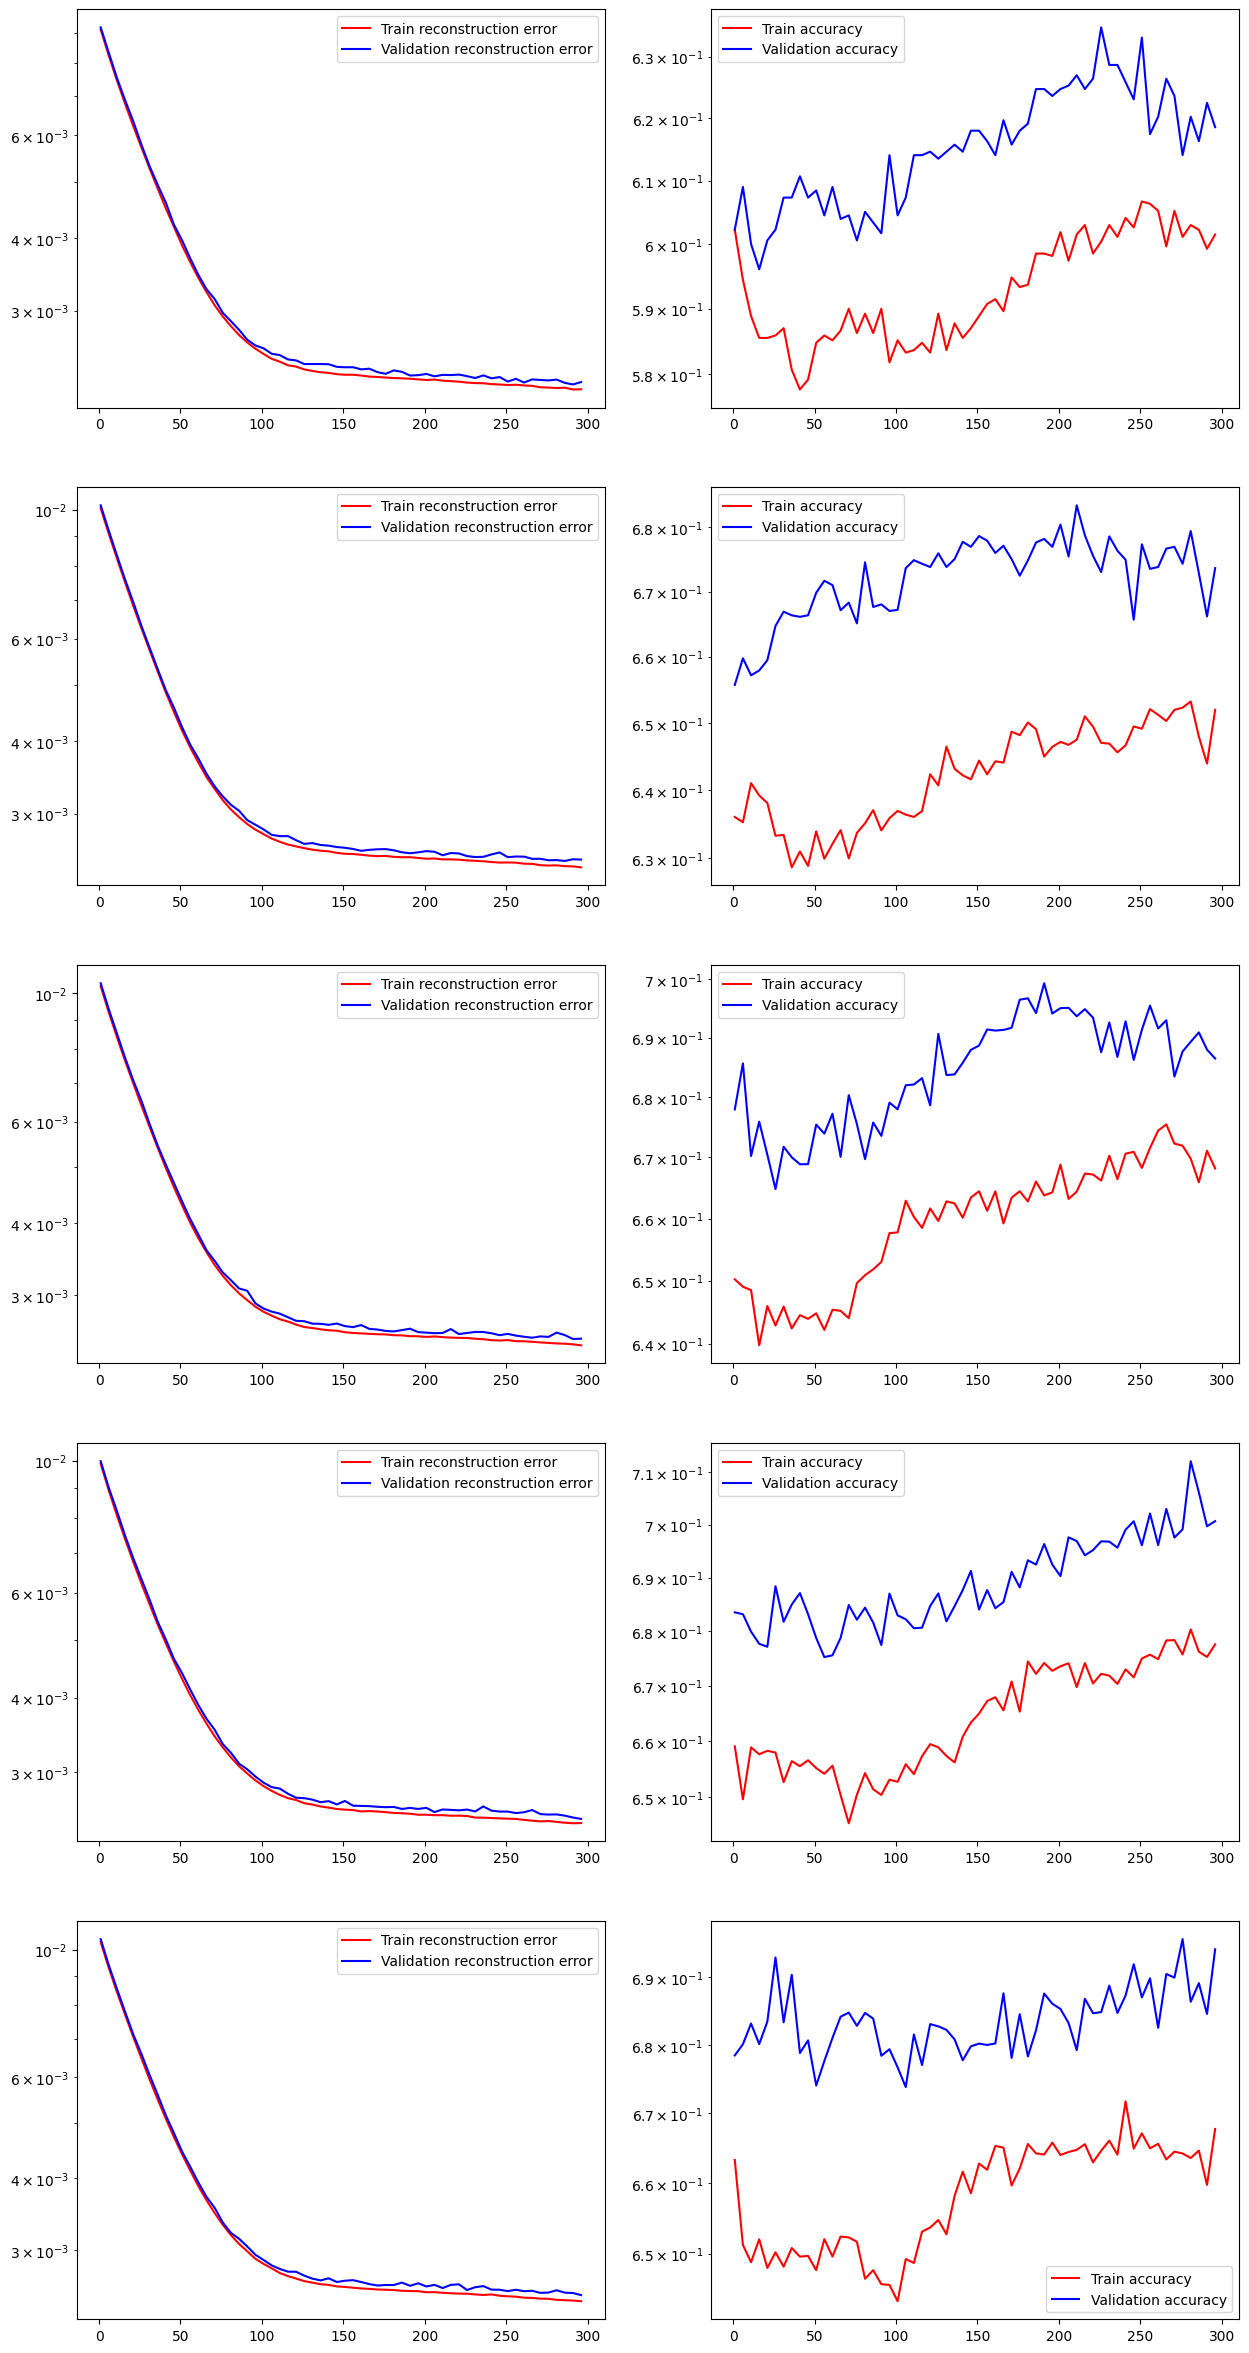

[6.460674157303369e-05, 0.0006449438202247191, 0.006544943820224717, 0.06679775280898877, 0.6601123595505618]


In [11]:
import matplotlib.pyplot as plt
# epochs = [(i * 5) + 1 for i in range(len(tr))]
max_q = 8
min_q = 4
ntest = 10
rows = max_q - min_q + 1
fig, ax = plt.subplots(nrows=rows, ncols=2, figsize=(15, 30))
n_epochs = 300
mva = [0] * rows
a = None
b = None
c = None
d = None
for i in range(rows):
    for j in range(ntest):
        train_dl, val_dl, test_dl = get_splits(ds, test_split=0.01, validation_split=0.4, batch_size=8)
        print(f"{i+min_q} QUBITS TEST NUMBER #{j+1}/{ntest}")
        hae = HAE_TQ(ds[0][0].shape[0], min_q + 1).to(device)
        tr, ta, vr, va = training(hae, train_dl, val_dl, epochs=n_epochs, log=False)
        a = tr if a is None else [v + tr[i] for i, v in enumerate(a)] 
        b = ta if b is None else [v + ta[i] for i, v in enumerate(b)] 
        c = vr if c is None else [v + vr[i] for i, v in enumerate(c)] 
        d = va if d is None else [v + va[i] for i, v in enumerate(d)] 
        mva[i] += max(va)
    a = [v / ntest for i, v in enumerate(a)]
    b = [v / ntest for i, v in enumerate(b)]
    c = [v / ntest for i, v in enumerate(c)]
    d = [v / ntest for i, v in enumerate(d)]

    epochs = [(i * 5) + 1 for i in range(len(tr))]
    ax[i][0].set_yscale('log')
    ax[i][0].plot(epochs, a, c='r')
    ax[i][0].plot(epochs, c, c='b')
    ax[i][0].legend(["Train reconstruction error", "Validation reconstruction error"])
    ax[i][1].set_yscale('log')
    ax[i][1].plot(epochs, b, c='r')
    ax[i][1].plot(epochs, d, c='b')
    ax[i][1].legend(["Train accuracy", "Validation accuracy"])

mva = [v / ntest for _, v in enumerate(mva)]
plt.show()
print(mva)